<a href="https://colab.research.google.com/github/ngupta23/medium_articles/blob/main/pycaret_ts_arima_010_0000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install & Import Library




In [1]:
try:
  import pycaret
except:
  !pip install pycaret-ts-alpha

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pycaret.datasets import get_data
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Get Data and Setup PyCaret Experiment

In [3]:
#### Get data from data playground ----
y = get_data("1", folder="time_series/random_walk")

,x
0,186.268370
1,186.310486
2,185.399564
3,185.557593
4,184.903008


In [4]:
exp = TimeSeriesExperiment()
exp.setup(data=y, seasonal_period=1, fh=30, session_id=42)

,Description,Value
0,session_id,42
1,Original Data,"(340, 1)"
2,Missing Values,False
3,Transformed Train Set,"(310,)"
4,Transformed Test Set,"(30,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,Enforce Prediction Interval,False
8,Seasonal Period Tested,1
9,Seasonality Detected,False


## EDA

In [5]:
exp.plot_model()

In [6]:
exp.plot_model(plot="acf")
exp.plot_model(plot="pacf")

## Helper functions using PyCaret's Time Series Module

In [7]:
def summarize_model(model):
  """
  Provides statistical summary for some statistical models
  """
  # Statistical Summary Table
  try:
    print(model.summary())
  except:
    print("Summary does not exist for this model.")

In [8]:
def get_residual_properties(model, ddof: int=0):
  """
  Plots and displays variance of residuals
  """
  #### Residuals ----
  try:
    plot_data = exp.plot_model(model, plot="residuals", return_data=True)
    residuals = plot_data['data']
    residuals_var = residuals.std(ddof=ddof)**2
    print(f"Variance of Residuals: {residuals_var}")
  except:
    print("Residuals can not be extracted for this model.")

In [9]:
def plot_predictions(model):
  """
  Plots out-of-sample and in-sample predictions
  """
  # Out-of-Sample Forecast
  exp.plot_model(model)
  
  # In-Sample Forecast
  exp.plot_model(model, plot="insample")

## Train & Test Data Properties

In [10]:
# Get Train Data Properties
y_train = exp.get_config("y_train")
print(f"Train Start Index: {y_train.index.min()}\nTrain End Index: {y_train.index.max()}")

# Get Test Data Properties
y_test = exp.get_config("y_test")
print(f"Test Start Index: {y_test.index.min()}\nTest End Index: {y_test.index.max()}")

Train Start Index: 0
Train End Index: 309
Test Start Index: 310
Test End Index: 339


## Random Walk ARIMA Model

### Theoretical Calculations

In [11]:
train_data = pd.DataFrame({"y":y_train})
train_data['preds'] = y_train.shift(1)
train_data['split'] = "Train"

test_data = pd.DataFrame({'y': y_test})
test_data['preds'] = y_train.iloc[-1]
test_data['split'] = "Test"

data = pd.concat([train_data, test_data])
data['residuals'] = data['y'] - data['preds']
data.reset_index(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      340 non-null    int64  
 1   y          340 non-null    float64
 2   preds      339 non-null    float64
 3   split      340 non-null    object 
 4   residuals  339 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 13.4+ KB


In [12]:
y_train_mean = data.query("split=='Train'")['y'].mean()
resid_std = data.query("split=='Train'")['residuals'].std(ddof=0)
resid_var = resid_std**2

print(f"Mean of Training Data: {y_train_mean}")
print(f"Std Dev of Residuals: {resid_std}")
print(f"Variance of Residuals: {resid_var}")

Mean of Training Data: 186.59657396255017
Std Dev of Residuals: 0.9893406617031943
Variance of Residuals: 0.9787949448993144


[Text(0.5, 1.0, 'Theoretical Predictions')]

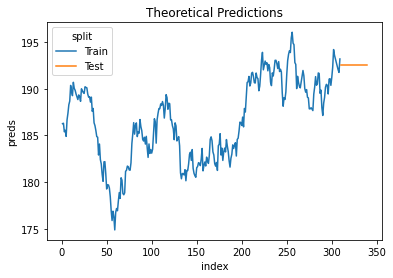

In [13]:
sns.lineplot(data=data, x="index", y="preds", hue="split").set(title="Theoretical Predictions")

But what about the confidence intervals? 95% Prediction Intervals Multiplier = 1.96

CHANGE: Confidence interval = Mean +/- 1.96 * Std of Residuals

In [14]:
import scipy.stats as st
alpha = 0.05

# 2 sided multiplier
multiplier = st.norm.ppf(1-alpha/2)

lower_interval = np.round(y_train_mean - multiplier * resid_std, 2)
upper_interval = np.round(y_train_mean + multiplier * resid_std, 2)
print(f"Prediction Interval: {lower_interval} - {upper_interval}")

Prediction Interval: 184.66 - 188.54


### Now let's build this model & compate to Theory

#### Pure Random Walk

In [15]:
model2a = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=False)

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,219.0,1.8274,1.9904,0.0095,0.0096,-1.0221
1,249.0,2.1118,2.4533,0.0110,0.0110,-0.0227
2,279.0,1.9092,2.2795,0.0100,0.0100,-0.9045
Mean,NaN,1.9495,2.2411,0.0102,0.0102,-0.6498
SD,NaN,0.1196,0.1909,0.0006,0.0006,0.4460


In [16]:
summarize_model(model2a)
get_residual_properties(model2a, ddof=0)
get_residual_properties(model2a, ddof=1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -435.205
Date:                Wed, 17 Nov 2021   AIC                            872.410
Time:                        19:38:39   BIC                            876.143
Sample:                             0   HQIC                           873.902
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9792      0.080     12.203      0.000       0.822       1.136
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.32   Pr

Variance of Residuals: 0.9787949448993651


Variance of Residuals: 0.9819728505646228


In [17]:
plot_predictions(model2a)

The calculations match exactly with the theoretical calculations. Hopefully this model has given us a good starting point to understand the inner workings of an ARIMA model. In the next set of FAQ's we will start covering the other parameters one by one and see the impact that they have on the model's behavior.

In [18]:
exp.check_stats(model2a, test="white_noise")

,Test,Test Name,Property,Setting,Value
0,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 24}",27.9957
1,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 48}",46.0732
2,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 24}",0.260223
3,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 48}",0.552117
4,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 24}",True
5,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 48}",True


#### Random Walk with Drift

In [19]:
model2b = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=True)

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,219.0,1.7202,1.8788,0.0090,0.0090,-0.8017
1,249.0,2.3373,2.6818,0.0122,0.0122,-0.2221
2,279.0,1.7762,2.1185,0.0093,0.0093,-0.6450
Mean,NaN,1.9446,2.2264,0.0102,0.0102,-0.5563
SD,NaN,0.2786,0.3366,0.0015,0.0014,0.2448


In [20]:
summarize_model(model2b)
get_residual_properties(model2b)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -435.141
Date:                Wed, 17 Nov 2021   AIC                            874.281
Time:                        19:38:40   BIC                            881.748
Sample:                             0   HQIC                           877.266
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0202      0.056      0.358      0.720      -0.090       0.131
sigma2         0.9788      0.080     12.208      0.000       0.822       1.136
Ljung-Box (L1) (Q):                   0.99   Jarque-

Variance of Residuals: 0.9787949448993144


In [21]:
plot_predictions(model2b)

In [22]:
exp.check_stats(model2b, test="white_noise")

,Test,Test Name,Property,Setting,Value
0,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 24}",27.9957
1,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 48}",46.0732
2,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 24}",0.260223
3,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 48}",0.552117
4,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 24}",True
5,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 48}",True


In [23]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [38]:
X_train = np.arange(len(y_train)).reshape(-1, 1)
reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
print(reg.intercept_, reg.coef_)

reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)
print(reg.intercept_, reg.coef_)

0.0 [0.91100847]
182.49857476130083 [0.02652427]


In [46]:
plot_data = exp.plot_model(model2b, plot="residuals", return_data=True)
residuals = plot_data['data']

In [47]:
X_train = np.arange(len(residuals)).reshape(-1, 1)
reg = LinearRegression(fit_intercept=False).fit(X_train, residuals)
print(reg.intercept_, reg.coef_)

reg = LinearRegression(fit_intercept=True).fit(X_train, residuals)
print(reg.intercept_, reg.coef_)

0.0 [8.83263796e-05]
-0.054145780235225434 [0.0003516]


In [48]:
model = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=True, trend='ct')
model

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,219.0,1.7743,2.3436,0.0093,0.0093,-1.8035
1,249.0,3.4014,3.9197,0.0179,0.0177,-1.6107
2,279.0,1.3269,1.6169,0.0069,0.0070,0.0417
Mean,NaN,2.1675,2.6267,0.0114,0.0113,-1.1241
SD,NaN,0.8914,0.9612,0.0047,0.0046,0.8281


ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend='ct',
      with_intercept=True)

In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -434.985
Date:                Wed, 17 Nov 2021   AIC                            875.971
Time:                        19:50:18   BIC                            887.171
Sample:                             0   HQIC                           880.448
                                - 310                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0343      0.117     -0.292      0.770      -0.264       0.196
drift          0.0004      0.001      0.530      0.596      -0.001       0.002
sigma2         0.9778      0.081     12.141      0.000       0.820       1.136
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.31   Prob(JB):                         0.94
Heteroskedasticity (H):               0.99   Skew:                            -0.04
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
plot_predictions(model)

## Inclusion of Constants

https://robjhyndman.com/hyndsight/arimaconstants/

Python ARIMA Parameters: https://github.com/alan-turing-institute/sktime/blob/main/sktime/forecasting/arima.py

In [62]:
#### with_intercept = True/False has no impact when trend is set
model = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=False, trend='c', verbose=False)
print(model.summary())

model = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=True, trend='c', verbose=False)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -435.141
Date:                Wed, 17 Nov 2021   AIC                            874.281
Time:                        20:13:45   BIC                            881.748
Sample:                             0   HQIC                           877.266
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0202      0.056      0.358      0.720      -0.090       0.131
sigma2         0.9788      0.080     12.208      0.000       0.822       1.136
Ljung-Box (L1) (Q):                   0.99   Jarque-

In [61]:
#### with_intercept = True/False has no impact when trend is set
model = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=False, trend='t', verbose=False)
print(model.summary())

model = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=True, trend='t', verbose=False)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -435.032
Date:                Wed, 17 Nov 2021   AIC                            874.063
Time:                        20:09:50   BIC                            881.530
Sample:                             0   HQIC                           877.048
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0002      0.000      0.582      0.560      -0.000       0.001
sigma2         0.9781      0.080     12.197      0.000       0.821       1.135
Ljung-Box (L1) (Q):                   1.02   Jarque-

In [63]:
#### with_intercept = True/False has no impact when trend is set
model = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=False, trend='ct', verbose=False)
print(model.summary())

model = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=True, trend='ct', verbose=False)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -434.985
Date:                Wed, 17 Nov 2021   AIC                            875.971
Time:                        20:14:04   BIC                            887.171
Sample:                             0   HQIC                           880.448
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0343      0.117     -0.292      0.770      -0.264       0.196
drift          0.0004      0.001      0.530      0.596      -0.001       0.002
sigma2         0.9778      0.081     12.141      0.0

In [60]:
model = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=False, trend='c', verbose=False)
print(model.summary())

#### with_intercept = True is same as adding a trend = 'c' (constant) in the model
model = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=True, verbose=False)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -435.141
Date:                Wed, 17 Nov 2021   AIC                            874.281
Time:                        20:08:47   BIC                            881.748
Sample:                             0   HQIC                           877.266
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0202      0.056      0.358      0.720      -0.090       0.131
sigma2         0.9788      0.080     12.208      0.000       0.822       1.136
Ljung-Box (L1) (Q):                   0.99   Jarque-

In [56]:
## File Bug Report in PyCarte when parameter takes a wrong value ...
model = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=False, trend='a')
model.summary()

IntProgress(value=0, description='Processing: ', max=4)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:04:21
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,ARIMA


,cutoff,MAE,RMSE,MAPE,SMAPE,R2


TypeError: ignored